<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/SemiSupervised_CoTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/DataDa2/images_train.zip

Archive:  gdrive/My Drive/DataDa2/images_train.zip
  inflating: images/image_000.npy    
  inflating: images/image_001.npy    
  inflating: images/image_002.npy    
  inflating: images/image_003.npy    
  inflating: images/image_004.npy    
  inflating: images/image_005.npy    
  inflating: images/image_006.npy    
  inflating: images/image_007.npy    
  inflating: images/image_008.npy    
  inflating: images/image_009.npy    
  inflating: images/image_010.npy    
  inflating: images/image_011.npy    
  inflating: images/image_012.npy    
  inflating: images/image_013.npy    
  inflating: images/image_014.npy    
  inflating: images/image_015.npy    
  inflating: images/image_016.npy    
  inflating: images/image_017.npy    
  inflating: images/image_018.npy    
  inflating: images/image_019.npy    


In [3]:
!unzip gdrive/My\ Drive/DataDa2/masks_train.zip

Archive:  gdrive/My Drive/DataDa2/masks_train.zip
  inflating: masks/mask_000.npy      
  inflating: masks/mask_001.npy      
  inflating: masks/mask_002.npy      
  inflating: masks/mask_003.npy      
  inflating: masks/mask_004.npy      
  inflating: masks/mask_005.npy      
  inflating: masks/mask_006.npy      
  inflating: masks/mask_007.npy      
  inflating: masks/mask_008.npy      
  inflating: masks/mask_009.npy      
  inflating: masks/mask_010.npy      
  inflating: masks/mask_011.npy      
  inflating: masks/mask_012.npy      
  inflating: masks/mask_013.npy      
  inflating: masks/mask_014.npy      
  inflating: masks/mask_015.npy      
  inflating: masks/mask_016.npy      
  inflating: masks/mask_017.npy      
  inflating: masks/mask_018.npy      
  inflating: masks/mask_019.npy      


In [4]:
import numpy as np
import pandas as pd

data = np.empty((0, 9))

for i in range(9):
    X = np.load('/content/images/image_00' + str(i) + '.npy')
    y = np.load('/content/masks/mask_00' + str(i) + '.npy')

    X1 = X[[0, 1, 2, 6, 7, 8, 9]]
    X1 = X1.reshape(7, -1).transpose()

    y = y.reshape(1, -1).transpose()

    # Calculate NDVI
    b8 = X[[6]].reshape(1, -1).transpose()
    b4 = X[[2]].reshape(1, -1).transpose()

    denominator = b8 + b4
    ndvi = np.where(denominator != 0, (b8 - b4) / denominator, 0)


    # Concatenate the slices with the new column

    Xy = np.concatenate((X1, y), axis=1)
    index = Xy.shape[1] - 1

    left_slice = Xy[:, :index]
    right_slice = Xy[:, index:]
    Xy = np.concatenate((left_slice, ndvi, right_slice), axis=1)

    # Concatenate the arrays along the first axis (number of features)
    data = np.concatenate((data, Xy), axis=0)




<ipython-input-4-4dd7f56490f6>:20: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.where(denominator != 0, (b8 - b4) / denominator, 0)


In [5]:

for i in range(10,20):
    X = np.load('/content/images/image_0' + str(i) + '.npy')
    y = np.load('/content/masks/mask_0' + str(i) + '.npy')
    X1 = X[[0, 1, 2, 6, 7, 8, 9]]
    X1 = X1.reshape(7, -1).transpose()
    y = y.reshape(1, -1).transpose()

    # Calculate NDVI
    b8 = X[[6]].reshape(1, -1).transpose()
    b4 = X[[2]].reshape(1, -1).transpose()
    denominator = b8 + b4
    ndvi = np.where(denominator != 0, (b8 - b4) / denominator, 0)

    # Concatenate the slices with the new column

    Xy = np.concatenate((X1, y), axis=1)
    index = Xy.shape[1] - 1

    left_slice = Xy[:, :index]
    right_slice = Xy[:, index:]
    Xy = np.concatenate((left_slice, ndvi, right_slice), axis=1)
    #Xy_ndvi = np.hstack((Xy, ndvi))

    # Concatenate the arrays along the first axis (number of features)
    data = np.concatenate((data, Xy), axis=0)


In [6]:

num = np.count_nonzero(data[:,-1])
nonzero = np.nonzero(data[:,-1])
zero = np.where(data[:,-1] == 0)[0]
labeled_data = data[nonzero]
unlabeled_data = data[zero]


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
#X_train, y_train, X_test, y_test = train_test_split(X1,y1, test_size=0.2, random_state=1)

# Step 3: Create training and testing sets
X_labeled, X_test_labeled, y_labeled, y_test_labeled = train_test_split(
    labeled_data[:, :-1],  # Features
    labeled_data[:, -1],   # Labels
    test_size=0.2,          # Adjust the test size as needed
    random_state=11         # Set a random seed for reproducibility
)


X_unlabeled= unlabeled_data[:, :-1]

In [8]:
del labeled_data, unlabeled_data

In [9]:
# Split unlabeled data into two parts for co-training
X_unlabeled_1, X_unlabeled_2 = np.split(X_unlabeled, 2)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create two Random Forest models for co-training
model_1 = RandomForestRegressor(n_estimators=10, random_state=42)
model_2 = RandomForestRegressor(n_estimators=10, random_state=42)


In [11]:
import tensorflow as tf

# Training loop for co-training
for epoch in range(3):
    # Train each model with labeled data using TensorFlow Dataset

    # Create TensorFlow Dataset from labeled data
    labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, y_labeled))
    labeled_dataset = labeled_dataset.shuffle(buffer_size=len(X_labeled), seed=42).batch(1024)

    for X_batch, y_batch in labeled_dataset:
        model_1.fit(X_batch, y_batch)
        model_2.fit(X_batch, y_batch)

    # Predict on unlabeled data using each model
    y_pred_1 = model_1.predict(X_unlabeled_1)
    y_pred_2 = model_2.predict(X_unlabeled_2)

    # Select confident predictions from each model
    confident_indices_1 = np.where(np.abs(y_pred_1 - y_pred_2) < 2)[0]
    confident_indices_2 = np.where(np.abs(y_pred_2 - y_pred_1) < 2)[0]

    # Use confident predictions to update labeled data
    X_labeled = np.concatenate((X_labeled, X_unlabeled_1[confident_indices_1],X_unlabeled_2[confident_indices_2]))
    y_labeled = np.concatenate((y_labeled, y_pred_1[confident_indices_1],y_pred_2[confident_indices_2]))



In [12]:
# Final training using all labeled data
model_1.fit(X_labeled, y_labeled)
model_2.fit(X_labeled, y_labeled)

# Evaluation
y_pred_test = (model_1.predict(X_test_labeled) + model_2.predict(X_test_labeled)) / 2.0
mse = mean_squared_error(y_test_labeled, y_pred_test)
print("Mean Squared Error:", mse)


Mean Squared Error: 55.237075660194215


RMSE: 7.432164937633867


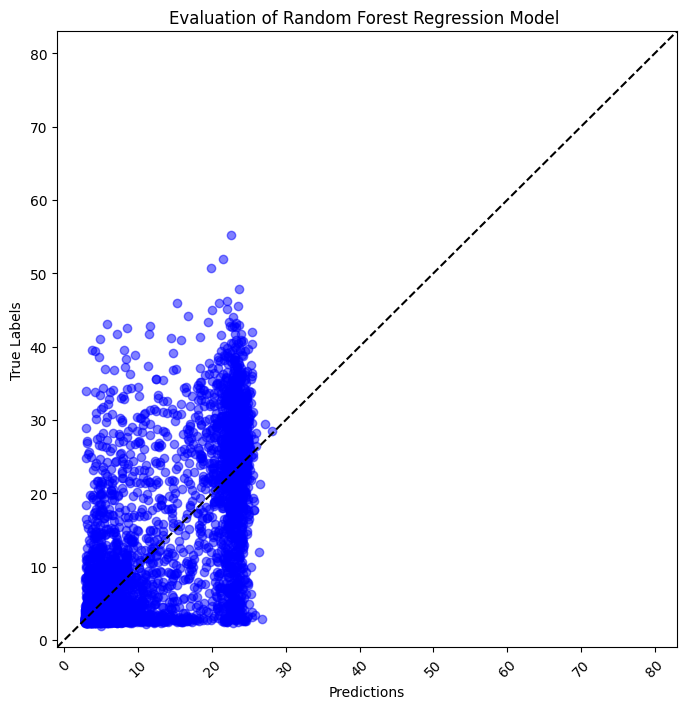

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.metrics import mean_squared_error

# compute RMSE
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test_labeled, y_pred_test))))

# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(y_pred_test, y_test_labeled, color="blue", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-1, 83], [-1, 83], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-1, 83])
plt.ylim([-1, 83])
plt.title("Evaluation of Random Forest Regression Model ")
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_labeled, y_pred_test)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 4.886970688022066
